In [48]:
import argparse
import json
import math
import os
import pickle
import random
import re
from pathlib import Path, PureWindowsPath
from queue import deque
from time import time
from urllib.parse import quote
import uuid
import cv2
import matplotlib.pyplot as plt
import numpy as np
from lib.utils.overlap_image import overlap_contour, overlap_figure

# from training.utils_custom import cd
import pandas as pd
import seaborn as sns
from histolab.filters.image_filters import RgbToHsv
from histolab.filters.morphological_filters import (
    BinaryErosion,
    BinaryFillHoles,
    RemoveSmallHoles,
    RemoveSmallObjects,
)
from pprint import pprint
from IPython.core.display import HTML, display
from IPython.display import clear_output
from PIL import Image, ImageOps
from scipy.ndimage.morphology import binary_fill_holes, binary_opening
from scipy.sparse import csr_matrix
from skimage import exposure, filters
from skimage.filters import try_all_threshold
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    jaccard_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
)
from tqdm import tqdm

rgbtohsv = RgbToHsv()
erosion = BinaryErosion(disk_size=5)
fill_holes = BinaryFillHoles()
remove_holes = RemoveSmallHoles(area_threshold=10000)
remove_objects = RemoveSmallObjects(min_size=5000)

# 3 µm (valore minimo) ad uno di circa 40 µm (valore massimo). I valori medi invece sono tra i 6 e i 13 µm
# 25 : 72 = µm : px
to_px = lambda m: m * 72 / 25
to_m = lambda px: px * 25 / 72
to_area_m = lambda Apx: (25 / 72) ** 2 * Apx
area_mc = lambda Apx: (25 / 72) ** 2 * Apx * 1e-6  ## to mm²

# circ_area = lambda d: np.pi * (d / 2) ** 2

# min_area = circ_area(3)
# max_area = circ_area(40)
# mid_areas = circ_area(np.array([6, 13]))


def open_mask(path):
    im = str(path)
    return cv2.imread(im, cv2.IMREAD_GRAYSCALE)


def center(c):
    M = cv2.moments(c)
    if M["m00"] == 0:
        print(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return [cX, cY]


def tube_area(fname: str):
    fname = real_img_PATH / f"{fname}.jpg"
    rgb_img = Image.open(fname)

    with np.errstate(all="ignore"):
        hsv_img = rgbtohsv(rgb_img)
        last = np.array(hsv_img)[:, :, 2]
        sobel = filters.sobel(last)
        blurred = filters.gaussian(sobel, sigma=5.0)
        blurred = exposure.adjust_sigmoid(blurred)

    binary_image = blurred > (filters.threshold_otsu(blurred) * 0.67)

    image_remove_holes = remove_holes(binary_image)
    image_remove_holes = binary_opening(image_remove_holes, structure=np.ones((20, 20)))

    image_filled = remove_objects(image_remove_holes)
    image_remove_object = fill_holes(image_filled)
    mask = erosion(image_remove_object)
    return area_mc(mask.sum())


def mcc(TP, TN, FP, FN, N=None):
    if N == None:
        N = TN + TP + FN + FP
    if N == 0:
        return 1
    S = (TP + FN) / N
    P = (TP + FP) / N

    return (TP / N - S * P) / np.sqrt(0.001 + P * S * (1 - S) * (1 - P))


def missed_wrong_cysts_dict(gt, pred):
    cysts = {}

    gt_contours, _ = cv2.findContours(gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    pred_contours, _ = cv2.findContours(pred, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    gt_contours = np.array([c for c in gt_contours if c.size > 4])
    pred_contours = np.array(
        [c for c in pred_contours if c.size > 4 and cv2.contourArea(c) > 5]
    )

    gt_seps = np.array(
        [
            csr_matrix(cv2.fillPoly(np.zeros_like(gt), pts=[c], color=(1)))
            for c in gt_contours
        ],
        dtype=object,
    )

    pred_seps = np.array(
        [
            csr_matrix(cv2.fillPoly(np.zeros_like(gt), pts=[c], color=(1)))
            for c in pred_contours
        ],
        dtype=object,
    )

    detect_miss_list = np.array([False for _ in pred_seps])

    count = (i for i in range(len(gt_contours) + len(pred_contours)))

    for single_gt, c in zip(gt_seps, gt_contours):
        curr_detection = np.array(
            [single_gt.multiply(sing_p).count_nonzero() for sing_p in pred_seps],
            dtype=bool,
        )

        if curr_detection.any():
            best_p = np.argmax(
                [cv2.contourArea(cp) for cp in pred_contours[curr_detection]]
            )
            areas = (
                cv2.contourArea(c),
                cv2.contourArea(pred_contours[curr_detection][best_p]),
            )
            centers = (center(c), center(pred_contours[curr_detection][best_p]))
            cysts[next(count)] = {
                "state": "detected",
                "areas": areas,
                "centers": centers,
            }
            for c_p in np.hstack(
                (
                    pred_contours[curr_detection][:best_p],
                    pred_contours[curr_detection][best_p + 1 :],
                )
            ):
                areas = (cv2.contourArea(c), cv2.contourArea(c_p))
                centers = (center(c), center(pred_contours[curr_detection][best_p]))
                cysts[next(count)] = {
                    "state": "overcounted",
                    "areas": areas,
                    "centers": centers,
                }

        else:
            areas = (cv2.contourArea(c), None)
            centers = (center(c), None)
            cysts[next(count)] = {"state": "missed", "areas": areas, "centers": centers}

    sparse_gt = csr_matrix(gt)
    for single_pred, c in zip(pred_seps, pred_contours):
        if not single_pred.multiply(sparse_gt).count_nonzero():
            areas = (None, cv2.contourArea(c))
            centers = (None, center(c))
            cysts[next(count)] = {"state": "wrong", "areas": areas, "centers": centers}

    return cysts, len(gt_contours), len(pred_contours)


def write_results(folder, is_jpg=False):
    np.seterr("raise")
    datafile = folder / "summary_final.json"
    if datafile.exists():
        print(f"> {datafile} already exists!")
        return
    res_model_PATH = folder
    IM_dict = {}

    #     stack = deque([{}, {}])

    #     suffix = '*.jpg' if is_jpg else '*.png'

    paths = sorted(res_model_PATH.glob("*.png"))
    #     paths = random.sample(paths, 30)
    for i, pred in enumerate(tqdm(paths, desc=str(folder))):
        # File name
        name = pred.stem
        s = (
            {}
        )  # dict of cysts as {'state': state, 'areas': [AREA_real, AREA_pred], 'centers': [(x_r, y_r), (x_p, y_p)]}
        #         s.name = get_old_name(name)
        
        assert (real_mask_PATH / f"{name}.png").exists(), real_mask_PATH / f"{name}.png"
        gt = open_mask(real_mask_PATH / f"{name}.png")
        pred_img = open_mask(pred)
        
        s["cysts"], s["total_real"], s["total_pred"] = missed_wrong_cysts_dict(
            gt, pred_img
        )

        s["tube_area"] = tube_area(name)

        # s['#recall'] = s['detected']/(s['detected'] + s['missed'] + 0.0001)

        gt = gt.ravel()
        # gt = np.minimum(gt, np.ones_like(gt))
        pred_img = pred_img.ravel()
        # pred_img = np.minimum(pred_img, np.ones_like(pred_img))

        cf = confusion_matrix(gt, pred_img).ravel() if gt.any() else [0, 0, 0, 0]
        TN, FP, FN, TP = cf  # if len(cf)==4 else [0, 0, 0, 0]
        s["pxTP"] = int(TP)
        s["pxFN"] = int(FN)
        s["pxFP"] = int(FP)
        s["pxTN"] = int(TN)

        s["iou"] = float(TP / (TP + FN + FP + 0.001))
        s["recall"] = float(TP / (TP + FN + 0.001))
        s["precision"] = float(TP / (TP + FP + 0.001))
        s["mcc"] = float(mcc(TP, TN, FP, FN))

        IM_dict[name] = s
    #     pickle.dump(IM_dict, open(datafile, 'wb'))

    json.dump(IM_dict, open(datafile, "w"))

In [64]:
import warnings

warnings.filterwarnings("ignore")
ROOT = Path("artifacts") / "dataset:v1"
real_mask_PATH = ROOT / "masks-png"
real_img_PATH = ROOT / "images-all-nodivision"
# res_model_PATH = Path("cyst_checkpoints") / "Nature_v3"
res_model_PATH = Path("cyst_checkpoints") / "3d_lug21_256"

dirs = sorted(res_model_PATH.glob("crossval_tube_*"))
assert dirs, "No tubules to scan"

# write_results("2022-06-12 17:03:49" / "inference_3d", is_jpg=True)
for d in dirs:
    # TODO: remove if, used while training
    if not (d / "inference_3d").exists():
        print("Directory inference_3d not existing, skipping. Maybe needs to run inference_3d.py?")
        continue
    # write_results(d / "inference_3d", is_jpg=True) # TODO: USE THIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIS
    write_results(d / "result", is_jpg=True)

> cyst_checkpoints/3d_lug21_256/crossval_tube_0_k_0_seed_14_lotocv_arch_3d/result/summary_final.json already exists!
> cyst_checkpoints/3d_lug21_256/crossval_tube_0_k_0_seed_21_lotocv_arch_3d/result/summary_final.json already exists!
> cyst_checkpoints/3d_lug21_256/crossval_tube_0_k_0_seed_7_lotocv_arch_3d/result/summary_final.json already exists!
> cyst_checkpoints/3d_lug21_256/crossval_tube_1_k_0_seed_14_lotocv_arch_3d/result/summary_final.json already exists!
> cyst_checkpoints/3d_lug21_256/crossval_tube_1_k_0_seed_21_lotocv_arch_3d/result/summary_final.json already exists!
> cyst_checkpoints/3d_lug21_256/crossval_tube_1_k_0_seed_7_lotocv_arch_3d/result/summary_final.json already exists!
> cyst_checkpoints/3d_lug21_256/crossval_tube_2_k_0_seed_14_lotocv_arch_3d/result/summary_final.json already exists!
> cyst_checkpoints/3d_lug21_256/crossval_tube_2_k_0_seed_21_lotocv_arch_3d/result/summary_final.json already exists!
> cyst_checkpoints/3d_lug21_256/crossval_tube_2_k_0_seed_7_lotocv_

In [65]:
# img = cv2.imread("dataset/images/Dicembre 2020/ADPKD tubi 2-3.09.2020_CTRL 17/ADPKD tubi 2-3.09.2020_CTRL 17 A z-stack 3/ADPKD tubi CTRL, T4, LM609+T4, UO, UO+T4 p-ERK 2-3.09.2020_CTRL 17 lato  A 40x10.jpg", cv2.COLOR_BGR2GRAY)
# mask = cv2.imread("inference/tubule_1/ADPKD tubi CTRL, T4, LM609+T4, UO, UO+T4 p-ERK 2-3.09.2020_CTRL 17 lato  A 40x12.png", cv2.COLOR_BGR2GRAY)
# assert img is not None and mask is not None
# contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
# cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
# plt.figure(figsize = (20,20))
# plt.imshow(img)

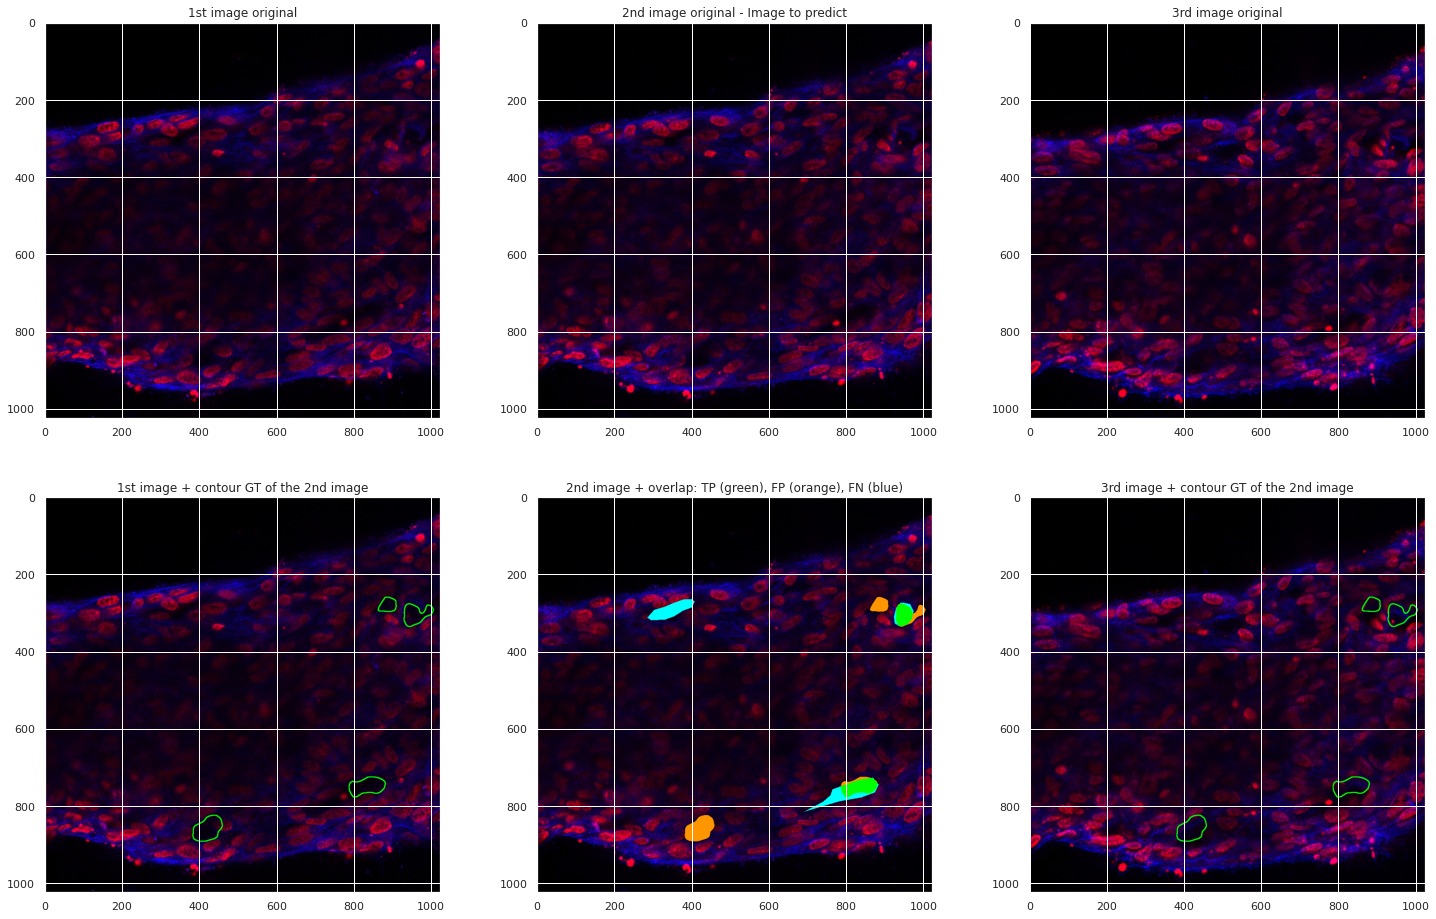

In [66]:
def show(img_path1, img_path2, img_path3, res_model_PATH, title=None):
    fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(25, 16))
    if title:
        fig.suptitle(title)

    img1 = cv2.imread(str(real_img_PATH / f"{img_path1}.jpg"))
    img2 = cv2.imread(str(real_img_PATH / f"{img_path2}.jpg"))
    img3 = cv2.imread(str(real_img_PATH / f"{img_path3}.jpg"))
    mask2 = cv2.imread(str(real_mask_PATH / f"{img_path2}.png"), cv2.COLOR_BGR2GRAY)
    pred2 = cv2.imread(str(res_model_PATH / f"{img_path2}.png"), cv2.COLOR_BGR2GRAY)
    assert img1 is not None and img2 is not None and img3 is not None, "An image does not exist for corresponding prediction, look at warnings above"
    # img_col_1 = overlap_figure(img1, mask2, pred2)
    img_col_1 = overlap_contour(img1, pred2)
    img_over_2 = overlap_figure(img2, mask2, pred2)
    img_col_3 = overlap_contour(img3, pred2)

    ax1[0].imshow(img1)
    ax1[0].set_title("1st image original")
    ax1[1].imshow(img2)
    ax1[1].set_title("2nd image original - Image to predict")
    ax1[2].imshow(img3)
    ax1[2].set_title("3rd image original")

    ax2[0].imshow(img_col_1)
    ax2[0].set_title("1st image + contour GT of the 2nd image")
    ax2[1].imshow(img_over_2)
    ax2[1].set_title("2nd image + overlap: TP (green), FP (orange), FN (blue)")
    ax2[2].imshow(img_col_3)
    ax2[2].set_title("3rd image + contour GT of the 2nd image")
    print('=========')
    plt.show()
    # plt.savefig(f"segmentation-images/{uuid.uuid4()}")

def show_all(res_model_PATH: Path, title=None):
    images = sorted(res_model_PATH.glob("*.png"))
    assert images, "No images inside this directory"
    # for idx in range(2, len(images)-1):
    for idx in range(5, 6):
        if images[idx-1].suffix != ".png":
            continue
        if images[idx].suffix != ".png":
            continue
        if images[idx+1].suffix != ".png":
            continue
        show(images[idx-1].stem, images[idx].stem, images[idx+1].stem, res_model_PATH)

show_all(list(res_model_PATH.iterdir())[1] / "inference_3d")

# Analyze results

In [67]:
from pathlib import Path
import json
import pandas as pd


def get_example_name(fname):
    """Get name of the example
    e.g. Dicembre 2020
    """
    
    FTYPES = {
        "ADPKD tubi CTRL, T4, LM609+T4, UO, UO+T4 p-ERK 2-3.09.2020_CTRL": "Dicembre 2020",
        "IF TUBI 18.12.2020": "Dicembre 2020",
        "TUBULI ADPKD 11.12.2020": "Dicembre 2020",

        "tubi don10_LM609 10ug.ml": "Luglio 2021 - Don10 LM609+10ugml",

        "ADPKD tubi CTRL, T4, LM609+T4, UO, UO+T4 p-ERK 2-3.09.2020_LM609+T4": "Luglio-Sett 2020",
        "ADPKD tubi CTRL, T4, LM609+T4, UO, UO+T4 p-ERK 2-3.09.2020_T4": "Luglio-Sett 2020",
        "ADPKD tubi CTRL, T4, LM609+T4, UO, UO+T4 p-ERK 2-3.09.2020_UO": "Luglio-Sett 2020",
        "TUBI 29-30.07.2020": "Luglio-Sett 2020",

        "IF ADPKD tubules 9-17.10.19": "Ott 2019",

        "IF 4-12.09.19": "Sett 2019",
    }
    
    ftype = None
    for key, value in FTYPES.items():
        if fname.startswith(key):
            ftype = value
    assert ftype is not None, f"File not categorized: {fname}"
    # assert ftype in results.keys(), f"File not in example list: {results.keys()}"
    return ftype



def get_results(path_dir):
    fpath = path_dir / "summary_final.json"
    assert fpath.exists(), f"Results file not existing, run inference_3d.py: {fpath}"
    with open(fpath) as f:
        json_content = json.load(f)

    cysts_ls = []
    for image in json_content:
        example = get_example_name(image)
        treatment = get_treatment(image)
        image = json_content[image]
        cysts = image["cysts"]
        for cyst in cysts:
            cyst = cysts[cyst]
            areas = cyst["areas"]
            area_real, area_pred = areas
            # We take the real size if not false positive, predicted size otherwise
            area = area_real if area_real is not None else area_pred
            invented = True if area_real is None else False
            # Get area size
            cysts_ls.append((int(area), cyst["state"], example, treatment, invented))
    return cysts_ls

inf_dir = res_model_PATH
# inf_dir = Path("cyst_checkpoints") / "Nature_v3"

def get_treatment(fname):
    """Get name of the example
    e.g. Dicembre 2020
    """
    
    TREATMENTS = {
        "DBD+T4": "DBD+T4",
        "UO+T4": "UO+T4",
        "LM609+T4": "LM609+T4",
        "LM609": "LM609", # Not sure this is a treatment
        "T4": "T4",
        "UO": "UO",
        "T3": "T3",
        "DBD": "DBD",
        "CTRL": "CTRL",
        "RESV": "RESV",
        "TETRAC": "TETRAC",
        "TRIAC": "TRIAC",
    }

    treatment = None
    for key, value in TREATMENTS.items():
        if key.lower() in fname.lower():
            treatment = value
            break
    assert treatment is not None, f"Treatment not categorized: {fname}"
    # assert ftype in results.keys(), f"File not in example list: {results.keys()}"
    return treatment

cysts = []
for exp_path in inf_dir.glob("crossval_tube_*"):
    # img_path = exp_path / "inference_3d"
    img_path = exp_path / "result" # TODO: USE THIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIS
    if (img_path / "summary_final.json").exists():
        print("✅ Using", img_path / "summary_final.json")
        cysts += get_results(img_path)
    else:
        print("⏩ Skipping", img_path / "summary_final.json")

cysts = pd.DataFrame(cysts, columns=["size", "status", "example", "treatment","invented"])
cysts = cysts.sort_values(["size"])
print("Total cysts", len(cysts))

✅ Using cyst_checkpoints/3d_lug21_256/crossval_tube_3_k_0_seed_7_lotocv_arch_3d/result/summary_final.json
✅ Using cyst_checkpoints/3d_lug21_256/crossval_tube_2_k_0_seed_21_lotocv_arch_3d/result/summary_final.json
✅ Using cyst_checkpoints/3d_lug21_256/crossval_tube_2_k_0_seed_7_lotocv_arch_3d/result/summary_final.json
✅ Using cyst_checkpoints/3d_lug21_256/crossval_tube_0_k_0_seed_21_lotocv_arch_3d/result/summary_final.json
✅ Using cyst_checkpoints/3d_lug21_256/crossval_tube_3_k_0_seed_14_lotocv_arch_3d/result/summary_final.json
✅ Using cyst_checkpoints/3d_lug21_256/crossval_tube_1_k_0_seed_14_lotocv_arch_3d/result/summary_final.json
✅ Using cyst_checkpoints/3d_lug21_256/crossval_tube_4_k_0_seed_7_lotocv_arch_3d/result/summary_final.json
✅ Using cyst_checkpoints/3d_lug21_256/crossval_tube_1_k_0_seed_21_lotocv_arch_3d/result/summary_final.json
✅ Using cyst_checkpoints/3d_lug21_256/crossval_tube_1_k_0_seed_7_lotocv_arch_3d/result/summary_final.json
✅ Using cyst_checkpoints/3d_lug21_256/cro

In [68]:
def compute_metrics(df):
    # Compute total
    df = df.transpose()
    df["sum"] = df.sum(axis=1)
    df = df.transpose()    
    # Show percentage
    pd.options.display.float_format = '{:.1%}'.format
    # Compute stats
    df["Accuracy-IOU"] = df["detected"] / (df["detected"] + df["wrong"] + df["missed"])
    df["Recall"] = df["detected"] / (df["detected"] + df["missed"])
    df["Precision"] = df["detected"] / (df["detected"] + df["wrong"])
    df = df.set_axis(['✅ detected', '❓ missed', 'overcounted', '❌ wrong', 'Accuracy-IOU', 'Recall', 'Precision'], axis=1)
    return df

def get_size_cat(dfs):
    """
    Split dataset in 6 categories and add column with the
    max value size for that category
    """
    dfs = np.array_split(dfs, 6)
    for df in dfs:
        df["size_cat"] = df["size"].max()
    return pd.concat(dfs)

def get_size_stats(cysts):
    df = get_size_cat(cysts)
    df = df.groupby(["size_cat", "status"]).count()
    df = df.pivot_table(values="size", columns="status", index="size_cat", fill_value=0)
    df = df.sort_values("size_cat", ascending=False)
    return df

df = get_size_stats(cysts)
df = compute_metrics(df)
df

,✅ detected,❓ missed,overcounted,❌ wrong,Accuracy-IOU,Recall,Precision
size_cat,,,,,,,
136201,402,108,73,786,31.0%,78.8%,33.8%
4353,374,208,18,769,27.7%,64.3%,32.7%
1976,295,281,4,790,21.6%,51.2%,27.2%
982,229,347,0,794,16.7%,39.8%,22.4%
478,32,154,0,1184,2.3%,17.2%,2.6%
135,2,49,0,1319,0.1%,3.9%,0.2%
sum,1334,1147,95,5642,16.4%,53.8%,19.1%


## By size

In [69]:
points = []
for i in range(1, 1500, 1):
    c = cysts
    # Remove if (smaller than i) and (invented)
    # If (bigger than i) or (not invented)
    c = c.loc[(c["size"] > i) | (~c.invented)]
    c.loc[c["size"] < i, "status"] = "missed"
    df = get_size_stats(c)
    stats = compute_metrics(df)
    stats = stats.filter(["Accuracy-IOU", "Recall", "Precision"])
    stats = stats.transpose()
    stats.columns = ["6", "5", "4", "3", "2", "1", "sum"]
    stats = stats.transpose()
    stats = stats.reset_index().melt("index")
    points.append(stats)
    print(i, end='\r')

counter = 0
for point in points:
    point["time"] = counter
    counter += 1

points = pd.concat(points)
# index: size_cat
points = points.set_index(["index", "variable", "time"])

In [70]:
points

,,,value
index,variable,time,
6,Accuracy-IOU,0,31.0%
5,Accuracy-IOU,0,27.7%
4,Accuracy-IOU,0,21.6%
3,Accuracy-IOU,0,16.7%
2,Accuracy-IOU,0,2.3%
...,...,...,...
4,Precision,1498,34.1%
3,Precision,1498,31.2%
2,Precision,1498,29.3%


In [71]:
import seaborn as sns

# sns.relplot(
#     data=points,
#     kind="line",
#     x="time",
#     y="value",
#     hue="variable",
#     col="index",
#     # style="index",
#     facet_kws=dict(sharex=False),
# )

points_sum = points.reset_index()
points_sum = points_sum[points_sum["index"] == "sum"]
points_sum = points_sum.drop("index", axis=1)
points_sum

,variable,time,value
6,Accuracy-IOU,0,16.4%
13,Recall,0,53.8%
20,Precision,0,19.1%
27,Accuracy-IOU,1,16.4%
34,Recall,1,53.8%
...,...,...,...
31450,Recall,1497,36.1%
31457,Precision,1497,32.7%
31464,Accuracy-IOU,1498,20.7%
31471,Recall,1498,36.1%


<AxesSubplot:xlabel='time', ylabel='value'>

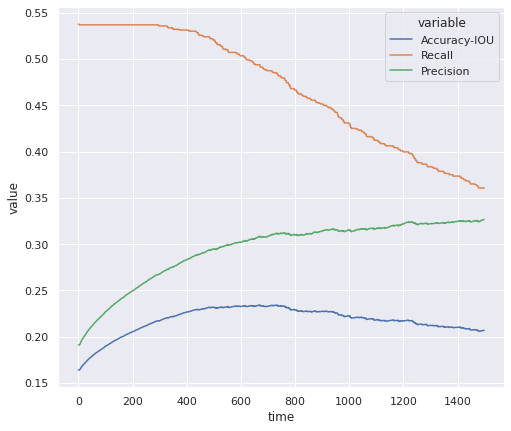

In [72]:
sns.lineplot(data=points_sum, x="time", y="value", hue="variable")

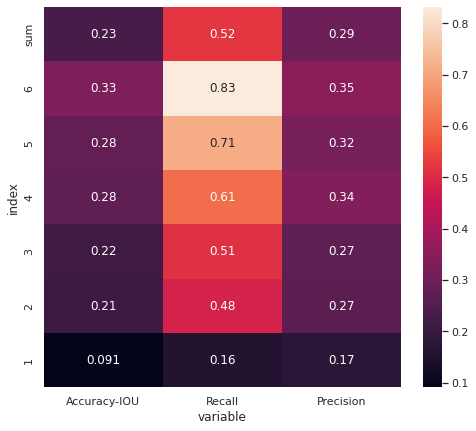

In [73]:
points_res = points.reset_index()
points_res = points_res[points_res.time == 500]
points_res = points_res.filter(["variable", "index", "value"])
points_res = pd.pivot(points_res, values="value", index="index", columns="variable")
points_res = points_res.filter(["Accuracy-IOU", "Recall", "Precision"])
points_res = points_res.sort_values(by="index", ascending=False)
sns.set(rc={'figure.figsize':(8,7)})
sns.heatmap(points_res, annot=True)
plt.show()

## By experiment

In [18]:
def get_detected(cysts):
    df = cysts.copy()
    df = df.groupby(["status", "example"]).count()
    df = df.reset_index()
    df = df.pivot(index="example", columns="status", values="size")
    return df

df = get_detected(cysts)
df = compute_metrics(df)
df

,✅ detected,❓ missed,overcounted,❌ wrong,Accuracy-IOU,Recall,Precision
example,,,,,,,
Luglio 2021 - Don10 LM609+10ugml,1397,1084,70,4021,21.5%,56.3%,25.8%
sum,1397,1084,70,4021,21.5%,56.3%,25.8%


## By teatment

In [19]:
def get_by_treatment(cysts):
    df = cysts.copy()
    df = df.groupby(["status", "treatment"]).count()
    df = df.reset_index()
    # print(df)
    df = pd.pivot_table(df, index="treatment", columns="status", values="size", fill_value=0)
    df = df.sort_values("detected", ascending=False)
    return df

df = get_by_treatment(cysts)
df = compute_metrics(df)
df

,✅ detected,❓ missed,overcounted,❌ wrong,Accuracy-IOU,Recall,Precision
treatment,,,,,,,
LM609,1397,1084,70,4021,21.5%,56.3%,25.8%
sum,1397,1084,70,4021,21.5%,56.3%,25.8%


           Accuracy-IOU  Recall  Precision
treatment                                 
LM609             21.5%   56.3%      25.8%
sum               21.5%   56.3%      25.8%


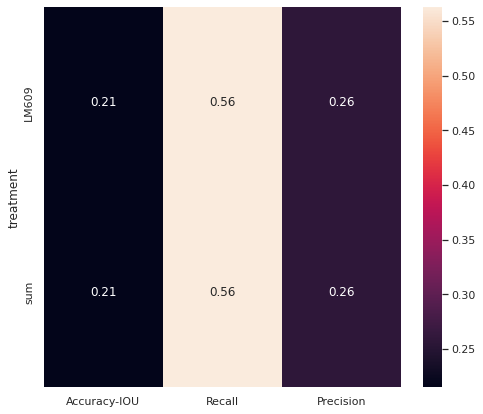

In [20]:
dff = df.filter(["Accuracy-IOU", "Recall", "Precision"])
print(dff)
sns.heatmap(dff, annot=True)
plt.show()

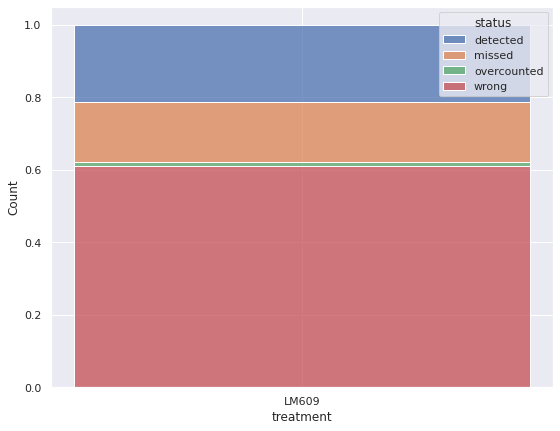

In [21]:
def get_cysts_proportion(cysts):
    df = cysts.copy()
    df = df.groupby(["status", "treatment"]).count()
    df = df.reset_index()    
    return df

def normalize_to_one(df):
    df = df.copy()
    df_count_by_treatment = df.groupby(["treatment"]).sum()["size"]
    # df.loc[df["treatment"] == df_count_by_treatment["treatment"], "size"] /= df_count_by_treatment["size"]
    # dff = df["example"] / df_count_by_treatment
    df = df.join(df_count_by_treatment, on="treatment", rsuffix="r")
    df["example"] /= df["sizer"]
    df = df.drop("invented", axis=1)
    return df

df = get_cysts_proportion(cysts)
df = normalize_to_one(df)
sns.set(rc={'figure.figsize':(9,7)})
sns.histplot(df, x="treatment", weights="example", hue="status", color='lightblue', multiple='stack')
plt.show()

## Cysts proportion

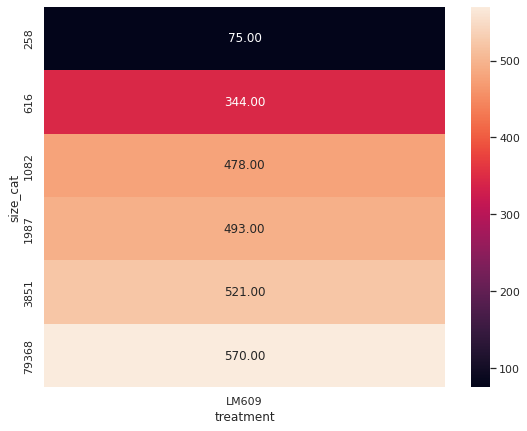

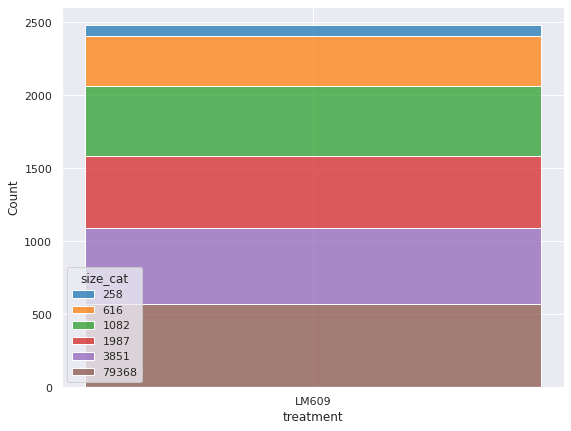

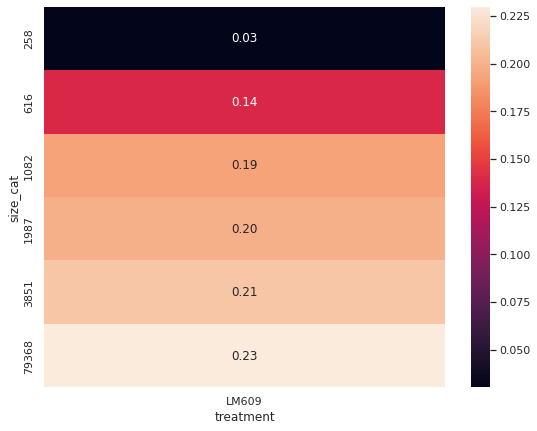

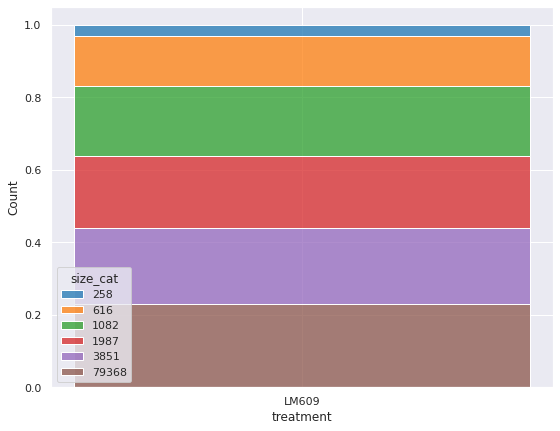

In [22]:
def heatmap_stackbarchart(df):
    df = df.copy()
    # Heatmap
    df = df.pivot_table(values="size_x", columns="treatment", index="size_cat", fill_value=0)
    sns.heatmap(df, annot=True, fmt = '.2f')
    plt.show()
    # Stacked bar chart
    df = df.stack().reset_index()
    df.columns = ["size_cat", "treatment", "size"]
    sns.histplot(df, x="treatment", weights="size", hue="size_cat",palette="tab10", multiple='stack')
    plt.show()

df = get_by_treatment(cysts)
df = get_size_cat(cysts)
df = df[(df["status"] == "missed") | (df["status"] == "detected")]
df = df.filter(["size_cat", "treatment", "size"])
df_by_treatment = df.groupby(["treatment"]).count()["size"].reset_index()
df = df.groupby(["size_cat", "treatment"]).count().reset_index()
df_by_treatment["treatment"] = df_by_treatment["treatment"].astype(str)
df = df.merge(df_by_treatment, on="treatment")

heatmap_stackbarchart(df)
df["size_x"] /= df["size_y"]
heatmap_stackbarchart(df)
plt.show()